# PD 5
## Piotr Fic
### Import bibliotek

In [1]:
import numpy as np
from numpy import random
import math
import pandas as pd
import matplotlib.pyplot as plt

## Funkcje pomocnicze

### Aktywacja

In [117]:
def softmax(y):
    exp = np.exp(y-np.max(y))
    return exp/exp.sum(axis = 0, keepdims=True)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_der(x):
    """Pochodna funkcji sigmoidalnej"""
    return sigmoid(x)*(1-sigmoid(x))

def linear(x):
    return x

def linear_der(x):
    return 1

def tanh(x):
    exp = np.exp(x)
    exp_ = np.exp(-x)
    return (exp - exp_)/(exp + exp_)

def tanh_der(x):
    return (1-tanh(x)**2)

def ReLu(x):
    return np.maximum(0, x)

def ReLu_der(x):
    return np.where(x>0, 1, 0)

In [85]:
linear([1,2,3])

[1, 2, 3]

In [86]:
linear_der([1, 2, 3])

1

### Miary

In [19]:
def MSE(predicted, real):
    return np.mean((predicted - real)**2)

def MAE(predicted, real):
    return np.mean(np.abs(predicted - real))

### Wykresy i dane

In [20]:
def predicted_real(predicted, real):
    plt.scatter(real, predicted, c='blue')
    p1 = max(max(predicted), max(real))
    p2 = min(min(predicted), min(real))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True values')
    plt.ylabel('Predictions')
    plt.title('Predictions visualization on test set')
    plt.axis('equal')
    plt.show()

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

## Rozszerzenie implementacji MLP
 - implementacja softmax-u na ostatniej warstwie, przyjmując za teoretyczną funkcję kosztu cross-entropy pochodna jest funkcją stałą
 - dostosowanie implementacji do zadania klasyfikacji

In [21]:
class Layer:
        
    def __init__(self, 
                 #Liczba neuronów w poprzedzającej i kolejnej warstwie
                 input_size: int, 
                 output_size: int,
                 #Domyślna funkcja aktywacyjna i jej pochodna                 
                 activation_fun = sigmoid, 
                 activation_fun_der = sigmoid_der,
                 ):
        
        #Wagi dla wszystkich neuronów - inicjalizacja Xavier
        self.biases = np.random.uniform(
            -math.sqrt(6)/ math.sqrt(input_size + output_size),
            math.sqrt(6)/ math.sqrt(input_size + output_size),
                    size=(output_size, 1)
                )
        
        self.weights = np.random.uniform(
            -math.sqrt(6)/ math.sqrt(input_size + output_size),
            math.sqrt(6)/ math.sqrt(input_size + output_size),
                    size=(output_size, input_size)
                )
            
        #Funkcja aktywacji i jej pochodna
        self.activation_fun = activation_fun
        self.activation_fun_der = activation_fun_der
    
    def predict(self, input):
        #Przekształca input z poprzedniej warstwy przez wagi i funkcję aktywacji 
        #Zwraca output do przekazania kolejnej warstwie
        return self.activation_fun(self.weights@input + self.biases)
    
    def forward(self, input):
        #Przekształca input z poprzedniej warstwy jedynie przez wagi
        return self.weights@input + self.biases

In [22]:
class Network:
    
    def __init__(self, layers: list, classif: bool):
        #classif
        self.classif = classif
        #Warstwy
        self.layers = layers
        self.momentum_w = [np.zeros(l.weights.shape) for l in layers]
        self.momentum_b = [np.zeros(l.biases.shape) for l in layers]
        self.g_w = [np.zeros(l.weights.shape) for l in layers]
        self.g_b = [np.zeros(l.biases.shape) for l in layers]
        
        if classif:
            self.layers[-1].activation_fun = softmax
        
    def predict(self, X):
        """Oblicza output na podstawie danych i parametrów warstw"""
        output = X.T
        for layer in self.layers:
            output = layer.predict(output)
        return output.T
    
    def forward(self, X):
        """Pełna metoda feedforward
        return: sumy, aktywacje"""
        sums = []
        activations = [X]
        activations_layer = X
        for layer in self.layers:
            sums_layer = layer.forward(activations_layer)
            sums.append(sums_layer)
            
            activations_layer = layer.activation_fun(sums_layer)
            activations.append(activations_layer)
            
        return sums, activations
    
    def backprop(self, X, Y):
        """Propagacja wsteczna błędu
        return: gradienty MSE"""
        
        #Wyliczenie feedforward obecnymi parametrami
        sums, activations = self.forward(X)
        
        #Macierze na poprawki parametrów
        delta_biases = []
        delta_weights = []
        
        n_layers = len(self.layers)
        err = [None]*n_layers
        
        #Wyliczenie err ostatniej warstwy
        if self.classif:
            err[-1] = Y - activations[-1]
        else:
            err[-1] = (Y - activations[-1])*self.layers[-1].activation_fun_der(sums[-1])
        
        #Propagacja wsteczna
        for i in reversed(range(len(err) -1)):
            act_f_der = self.layers[i].activation_fun_der(sums[i])
            err[i] = (self.layers[i+1].weights.transpose()@err[i+1]) * act_f_der 
            
        #Batch size
        batch_size = Y.shape[1]
        delta_biases = [e@np.ones((batch_size, 1))/float(batch_size) 
                        for e in err]
        delta_weights = [np.dot(e, activations[i].transpose())/float(batch_size) 
                        for i, e in enumerate(err)]
        
        return delta_biases, delta_weights
    
    def train(self, X, Y, 
              batch_size = 1, 
              etha = 0.001, 
              tol = 10**(-6), 
              n_iter = 500, 
              #Lambda dla momentum
              l_m = 0,
              #Beta dla RMSProp
              beta = 1,
              verbose = False):
        
        it = 0
        while it<n_iter:
            #Losowość przed podziałem zbioru, ziarno zapewnia identyczną permutację
            #w zmiennych objaśnających i zmiennej celu
            idx = random.permutation(X.shape[0])
            X_train = np.copy(X[idx])
            Y_train = np.copy(Y[idx])
            
            self.batch_gd(X_train, Y_train, batch_size, etha, l_m, beta)
            
            #Wizualizacja procesu uczenia
            if(verbose):
                print("Epoche " + str(it) + " finished")
                for i in range(len(self.layers)):
                    print("Warstwa " + str(i) + " wagi:")
                    print(self.layers[i].weights)
                    print("Warstwa " + str(i) + " bias-y:")
                    print(self.layers[i].biases)
                print("\n")
            
            it += 1
            
        return it
    
    def gd(self, X, Y, etha, l_m, beta):
        """Trening sieci podstawową metodą Gradient Descent"""
        b, w = self.backprop(X, Y)
        for i in range(len(self.layers)):
            #Aktualizacja momentum
            self.momentum_w[i] = w[i]+l_m*self.momentum_w[i]
            self.momentum_b[i] = b[i]+l_m*self.momentum_b[i]
            
            #Aktualizacja RMSProp
            self.g_w[i] = (1-beta)*w[i]*w[i]+beta*self.g_w[i]
            self.g_b[i] = (1-beta)*b[i]*b[i]+beta*self.g_b[i]
        
            l = self.layers[i]
            if(beta):
                l.biases = l.biases + etha*self.momentum_b[i] + (etha*b[i])/np.sqrt(0.00001+self.g_b[i]) 
                l.weights = l.weights + etha*self.momentum_w[i] + (etha*w[i])/np.sqrt(0.00001+self.g_w[i])
            else:
                l.biases = l.biases + etha*self.momentum_b[i]
                l.weights = l.weights + etha*self.momentum_w[i]
            
        return
    
    def batch_gd(self, X, Y, batch_size, etha, l_m, beta):
        """Trening sieci metodą Mini-batch Gradient Descent"""
        #Metoda train uprzednio dokonuje permutacji zbioru
        #Wywołanie metody gradient descent na kolejnych batch-ach
        i=0
        while(i<len(Y)):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            i += batch_size
            self.gd(x.T, y.T, etha, l_m, beta)
        return
        

# Test działania

In [34]:
def one_hot(y):
    y = y.astype(int)
    n_values = np.max(y) + 1
    return np.eye(n_values)[y.T][0]

def prepear_classif(df_train_p, df_test_p):
    df_train = pd.read_csv(df_train_p)
    df_test = pd.read_csv(df_test_p)
    #Separacja wektorów cech i odpowiedzi
    x_train, x_test = df_train.iloc[:, 0:2], df_test.iloc[:, 0:2]
    x_train, x_test = np.array(x_train), np.array(x_test)
    y_train, y_test = np.array(df_train.iloc[:, 2:3]), np.array(df_test.iloc[:, 2:3])
    #Normalizacja
    x_train, x_test = normalize(x_train), normalize(x_test)
    return x_train, one_hot(y_train), x_test, one_hot(y_test)

def prepear_data(df_train_p, df_test_p):
    df_train = pd.read_csv(df_train_p)
    df_test = pd.read_csv(df_test_p)
    #Separacja wektorów cech i odpowiedzi
    x_train, x_test = df_train.iloc[:, 1], df_test.iloc[:, 1]
    x_train, x_test = np.array(x_train), np.array(x_test)
    y_train, y_test = np.array(df_train.iloc[:, 2:3]), np.array(df_test.iloc[:, 2:3])
    #Normalizacja
    x_train, x_test = normalize(x_train), normalize(x_test)
    y_train, y_test = normalize(y_train), normalize(y_test)
    return x_train.reshape(-1, 1), y_train.reshape(-1, 1), x_test, y_test

In [24]:
def acc(x, y):
    return (x==y).mean()

In [105]:
def exp_plot(sig, lin, tanh, relu, ep):
    plt.plot(range(ep), sig, label = "sigmoid")
    plt.plot(range(ep), lin, label = "linear")
    plt.plot(range(ep), tanh, label = "tanh")
    plt.plot(range(ep), relu, label = "ReLu")
    plt.legend()
    plt.title("MSE during training on training set.")
    plt.show()

### architektury

In [122]:
#1-5-5-1
def arch_2(f, f_d):
    l1 = Layer(1, 5, activation_fun=f, activation_fun_der=f_d)
    l2 = Layer(5, 5, activation_fun=f, activation_fun_der=f_d)
    l3 = Layer(5, 1, activation_fun=linear, activation_fun_der=linear_der)
    return Network([l1, l2, l3], classif=False)

## Regresja
### df: steps-large

In [123]:
x_train, y_train, x_test, y_test = prepear_data("./mio1/regression/steps-large-training.csv",
                                               "./mio1/regression/steps-large-test.csv")


In [124]:
n_sig = arch_2(sigmoid, sigmoid_der)
n_lin = arch_2(linear, linear_der)
n_tanh = arch_2(tanh, tanh_der)
n_relu = arch_2(ReLu, ReLu_der)

ep = 100
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.1)
    res = n_sig.predict(x_train)
    sig[i] = MSE(y_train, res)
    #linear
    n_lin.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_lin.predict(x_train)
    lin[i] = MSE(y_train, res)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_tanh.predict(x_train)
    tan[i] = MSE(y_train, res)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_relu.predict(x_train)
    relu[i] = MSE(y_train, res)

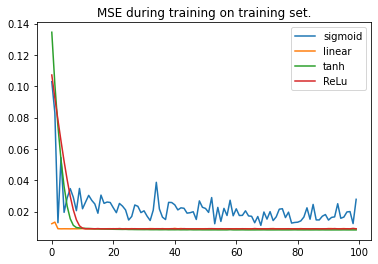

In [126]:
exp_plot(sig, lin, tan, relu, ep)

In [100]:
ep = 100
scores = [0]*ep
#scoress = [0]*ep

for i in range(ep):
    nn.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = nn.predict(x_train)
    #pred = np.argmax(res, axis=1)
    scores[i] = MSE(y_train, res)
    
#     nns.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.7, etha = 0.01)
#     res = nns.predict(x_train)
#     pred = np.argmax(res, axis=1)
#     scoress[i] = acc(train_true, pred)

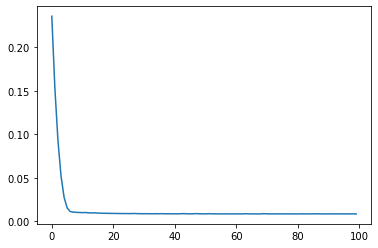

In [101]:
plt.plot(range(ep), scores)

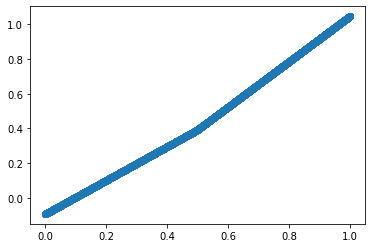

In [102]:
plt.scatter(x_train, res)

## df: Easy

In [103]:
x_train, y_train, x_test, y_test = prepear_data("./mio1/classification/easy-training.csv",
                                               "./mio1/classification/easy-test.csv")
train_true = np.argmax(y_train, axis=1)
test_true = np.argmax(y_test, axis=1)

In [113]:
#softmax
l1 = Layer(2, 10)
l2 = Layer(10, 2, activation_fun=softmax)
nn = Network([l1, l2], classif=True)
#sigmoid
l1 = Layer(2, 10)
l2 = Layer(10, 2)
nns = Network([l1, l2], classif=False)

In [114]:
ep = 100
scores = [0]*ep
scoress = [0]*ep

for i in range(ep):
    nn.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.7, etha = 0.01)
    res = nn.predict(x_train)
    pred = np.argmax(res, axis=1)
    scores[i] = acc(train_true, pred)
    
    nns.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.7, etha = 0.01)
    res = nns.predict(x_train)
    pred = np.argmax(res, axis=1)
    scoress[i] = acc(train_true, pred)

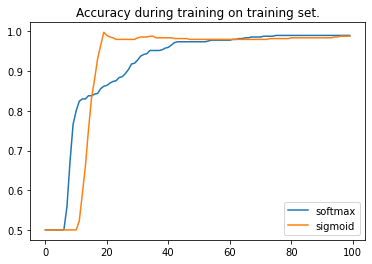

In [115]:
exp_plot(scores, scoress, ep)

### ACC: test set

In [116]:
res = nn.predict(x_test)
pred = np.argmax(res, axis=1)
acc(test_true, pred)

0.982

## df: Rings

In [119]:
x_train, y_train, x_test, y_test = prepear_data("./mio1/classification/rings3-regular-training.csv",
                                               "./mio1/classification/rings3-regular-test.csv")
train_true = np.argmax(y_train, axis=1)
test_true = np.argmax(y_test, axis=1)

In [120]:
#softmax
l1 = Layer(2, 10)
l2 = Layer(10, 10)
l3 = Layer(10, 3, activation_fun=softmax)
nn = Network([l1, l2, l3], classif=True)
#sigmoid
l1 = Layer(2, 10)
l2 = Layer(10, 10)
l3 = Layer(10, 3)
nns = Network([l1, l2, l3], classif=False)

In [121]:
ep = 500
scores = [0]*ep
scoress = [0]*ep

for i in range(ep):
    nn.train(x_train, y_train, batch_size=300, n_iter=1, beta=0.9, l_m = 0.99, etha = 0.1)
    res = nn.predict(x_train)
    pred = np.argmax(res, axis=1)
    scores[i] = acc(train_true, pred)
    
    nns.train(x_train, y_train, batch_size=300, n_iter=1, beta=0.9, l_m = 0.99, etha = 0.1)
    res = nns.predict(x_train)
    pred = np.argmax(res, axis=1)
    scoress[i] = acc(train_true, pred)

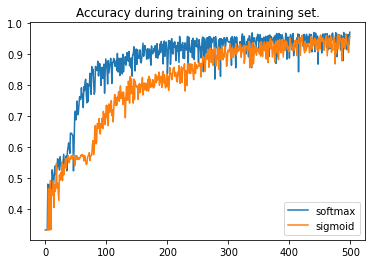

In [122]:
exp_plot(scores, scoress, ep)

### ACC: test set

In [123]:
res = nn.predict(x_test)
pred = np.argmax(res, axis=1)
acc(test_true, pred)

0.956

### Wizualizacja klasyfikacji: test set

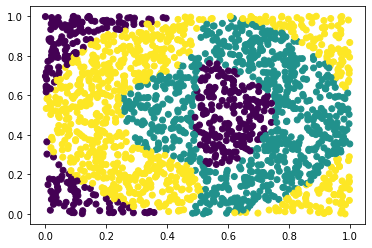

In [124]:
plt.scatter(x_test.T[0], x_test.T[1], c = pred)

## df: Xor

In [144]:
x_train, y_train, x_test, y_test = prepear_data("./mio1/classification/xor3-training.csv",
                                               "./mio1/classification/xor3-test.csv")
train_true = np.argmax(y_train, axis=1)
test_true = np.argmax(y_test, axis=1)

In [153]:
#softmax
l1 = Layer(2, 10)
l2 = Layer(10, 10)
l3 = Layer(10, 2, activation_fun=softmax)
nn = Network([l1, l2, l3], classif=True)
#sigmoid
l1 = Layer(2, 10)
l2 = Layer(10, 10)
l3 = Layer(10, 2)
nns = Network([l1, l2, l3], classif=False)

In [154]:
ep = 500
scores = [0]*ep
scoress = [0]*ep

for i in range(ep):
    nn.train(x_train, y_train, batch_size=20, n_iter=1, beta=0.7, l_m = 0.99, etha = 0.1)
    res = nn.predict(x_train)
    pred = np.argmax(res, axis=1)
    scores[i] = acc(train_true, pred)
    
    nns.train(x_train, y_train, batch_size=20, n_iter=1, beta=0.7, l_m = 0.99, etha = 0.1)
    res = nns.predict(x_train)
    pred = np.argmax(res, axis=1)
    scoress[i] = acc(train_true, pred)

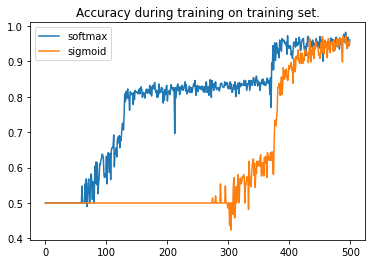

In [155]:
exp_plot(scores, scoress, ep)

### ACC: test set

In [156]:
res = nn.predict(x_test)
pred = np.argmax(res, axis=1)
acc(test_true, pred)

0.92

### Wizualizacja klasyfikacji: test set

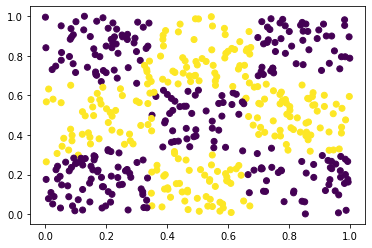

In [157]:
plt.scatter(x_test.T[0], x_test.T[1], c = pred)

## Wnioski
- zaimplementowana sieć MLP bardzo dobrze radzi sobie z zadaniem klasyfikacji
- warto zauważyć, że modele były w stanie nauczyć się również skomplikowanych zależności nieliniowych ze zbiorów "rings" i "xor"
- implementacja z wykorzystaniem funkcji softmax aktywacji ostatniej warstwy jest stabilniejsza i szybciej zbiega do rozwiązania